In [95]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
%matplotlib inline

In [96]:
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

from itertools import cycle, islice
from sklearn import metrics

from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

# Generate data sets

In [97]:
ns = 2000

centers = [[2, 2], [-2, -2], [2, -2]]

blobs_close = make_blobs(n_samples=ns, centers=centers, cluster_std=1, n_features=2,random_state=42)
blobs_far = make_blobs(n_samples=ns, centers=centers, cluster_std=0.5, n_features=2,random_state=42)

X, y = make_blobs(n_samples=ns, centers=centers, cluster_std=0.5, n_features=2,random_state=42)
transformation = [[1.5*0.6, -0.6*1.5], [-0.4*1.5, 0.8*1.5]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

datasets = [blobs_close, blobs_far, aniso]

# Clustering algorithms

In [98]:
def runClusteringAlgos(datasets, params):
    output = []
    for data in datasets:
        X, y = data
        X = normalize(X)
    
        #k-means
        y_kmeans = KMeans(n_clusters=params['n_clusters'], random_state=42).fit_predict(X)
    
        # mean-shift
        if 'bandwidth' not in params.keys():
            bandwidth = estimate_bandwidth(X, quantile=params['quantile'])
        else:
            bandwidth = params['bandwidth']
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X)
        y_meanshift = ms.labels_
    
        # spectral clustering
        y_spectral = SpectralClustering(n_clusters=params['n_clusters']).fit_predict(X)
    
        # affinity propagation
        ap = AffinityPropagation(damping=params['damping'], preference=params['preference']).fit(X)
        y_affinity = ap.labels_
    
        output.append([y, y_kmeans, y_meanshift, y_spectral, y_affinity])

    return output


In [99]:
def plotAlgoOutput(output, datasets, algo_names, fs):
    plt.figure(figsize=fs) #figsize=(9 * 2 + 3, 12.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
    plot_num = 1
    ii = 0

    for otp, data in zip(output, datasets):
        X, y = data
        for y_pred, name in zip(otp, algo_names):
            plt.subplot(len(datasets), len(algo_names), plot_num)
            if ii == 0:
                plt.title(name, size=18)
            colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                                 '#f781bf', '#a65628', '#984ea3',
                                                 '#999999', '#e41a1c', '#dede00']),
                                          int(max(y_pred) + 1))))
            plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred])
            plt.xlim(-6.0, 6.0)
            plt.ylim(-6.0, 6.0)
            plt.xticks(())
            plt.yticks(())
        
            plot_num += 1
        ii += 1

    plt.show()

# Basic comparison

In [100]:
params = {'quantile':0.2, 'n_clusters':3, 'damping':.9, 'preference':-200}

In [101]:
output = runClusteringAlgos(datasets, params)

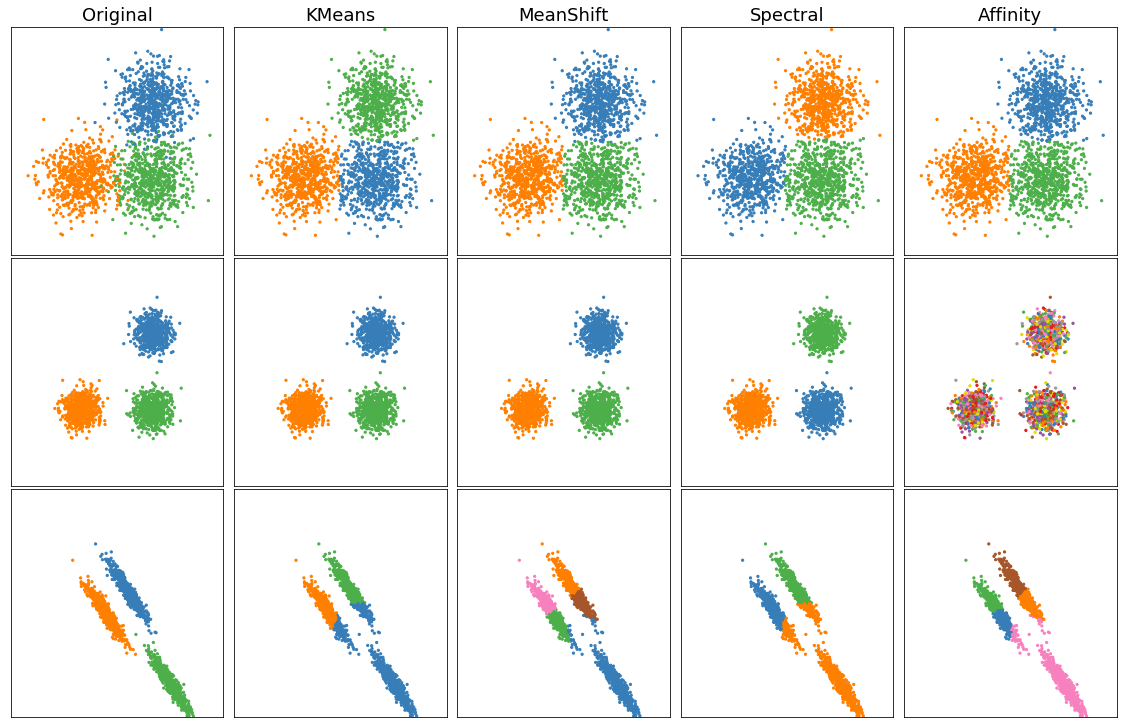

In [102]:
plotAlgoOutput(output, datasets, algo_names, (16, 10))

They all struggle with anisotropic data.  In theory Spectral should be better than K-Means (affinity used is 'rbf'). Maybe I need to use a different gamma (higher, to localize better).

# Increase number of clusters for K-Means and Spectral

In [103]:
params2 = {'quantile':0.2, 'n_clusters':4, 'damping':.9, 'preference':-200}

In [104]:
output2 = runClusteringAlgos(datasets, params2)

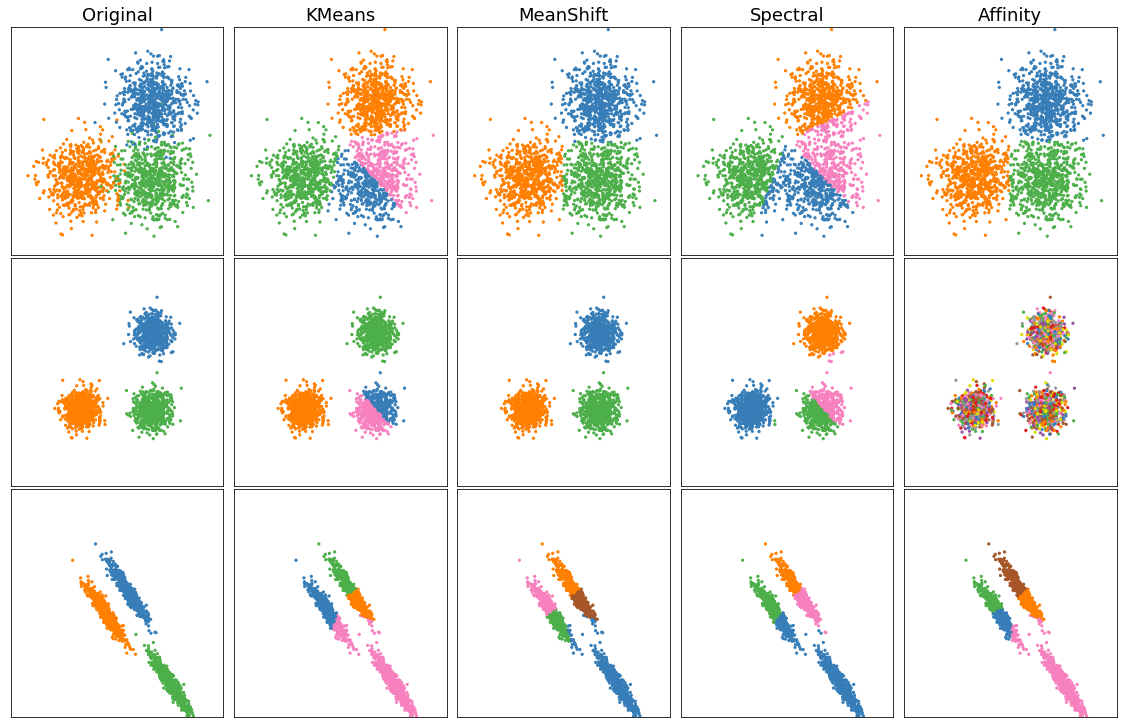

In [105]:
plotAlgoOutput(output2, datasets, algo_names, (16, 10))

It appears that the choice of number of clusters is quite important. A small mis-estimation of the number of clusters (from 3 to 4) can lead to weird results.

# Try multiple bandwidths for Mean Shift

Bandwidths obtained by using estimate_bandwidth(x, quantile=0.2) are 

blobs_close = 1.8
blobs_far = 0.95
aniso = 1.1

In [106]:
params3 = {'quantile':0.2, 'bandwidth':0.5,'n_clusters':3, 'damping':.9, 'preference':-200}

In [107]:
output3 = runClusteringAlgos(datasets, params3)

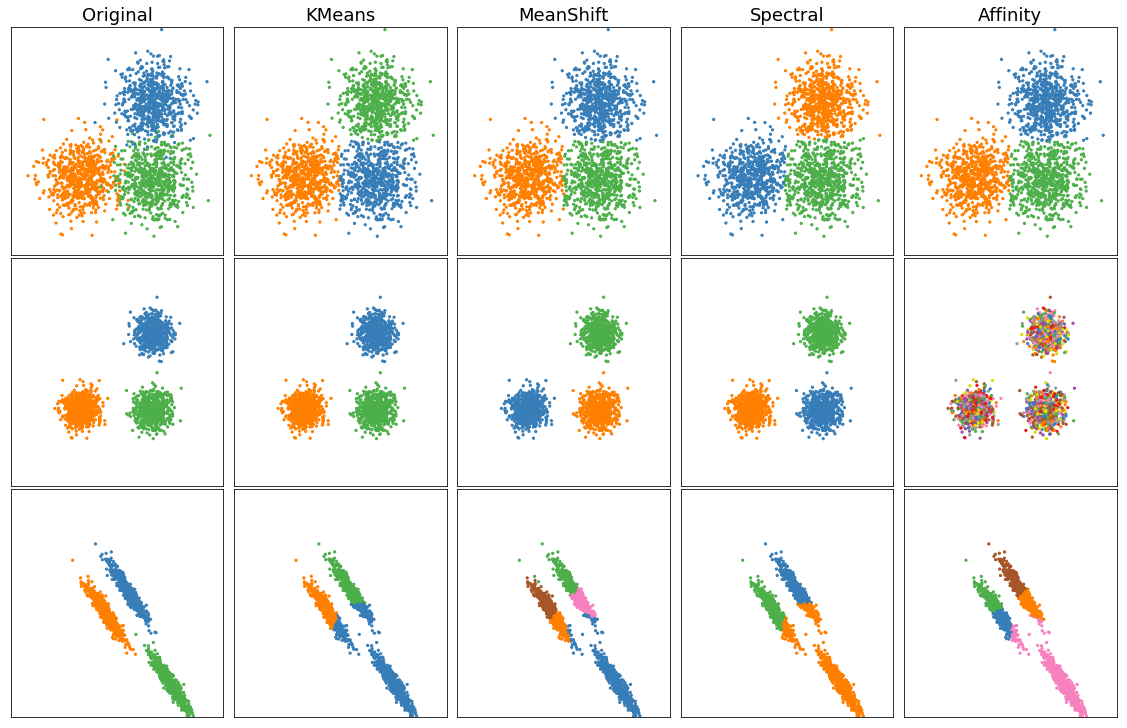

In [108]:
plotAlgoOutput(output3, datasets, algo_names, (16, 10))

In [109]:
params4 = {'quantile':0.2, 'bandwidth':2.5,'n_clusters':3, 'damping':.9, 'preference':-200}

In [110]:
output4 = runClusteringAlgos(datasets, params4)

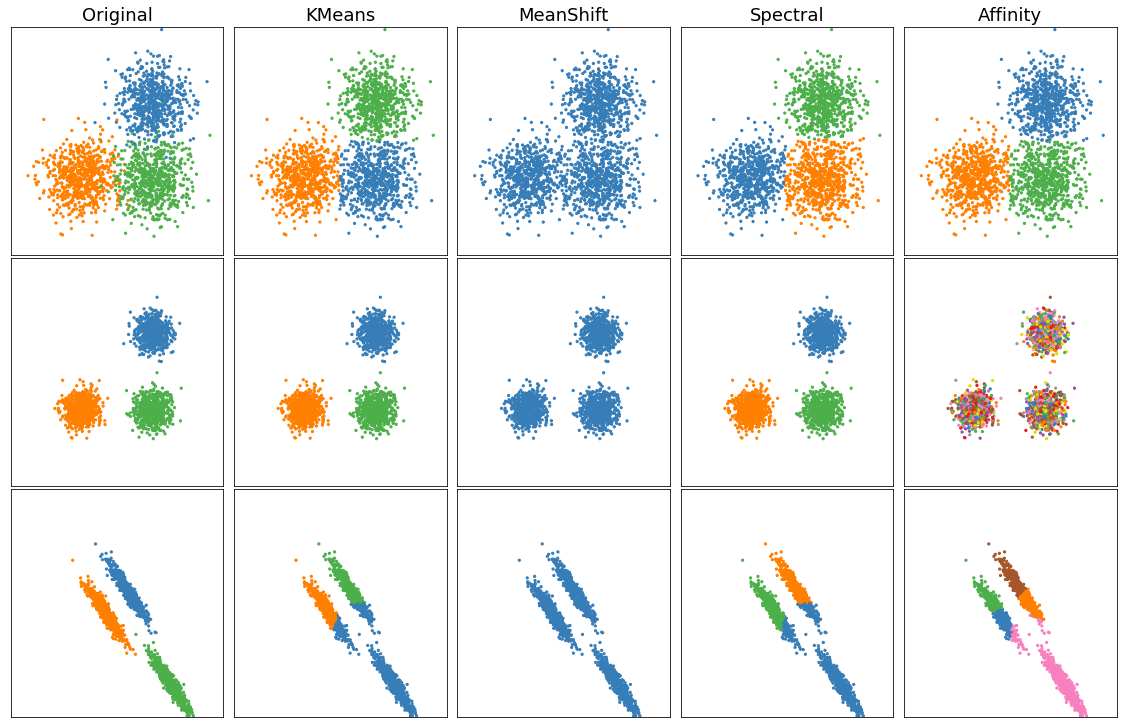

In [111]:
plotAlgoOutput(output4, datasets, algo_names, (16, 10))

# Questions

1. Affinity Propoagation seems to pick up on a lot more clusters than in should. Why?
2. What are best/better ways to deal with non-convex, anisotropic data? Mean Shift with 'rbf' and proper gamma?
3. Any clever way of choosing appropriate algorithm?
4. Spectral projects the data onto k principal components. Does using a random embedding (Johnson Lindenstrauss) make sense sometimes?
5. How does estimate_bandwidth work? What is the idea behind the algorithm?